# Fitting a generative model using standard divergences between measures
(Author: Jean Feydy; this notebook is not finished yet, as it lacks a LibKP backend.)

In this notebook, we show how to tune the parameters of a generative model to match it with an empirical distribution.
Having observed a sample $y_1, \dots, y_M \in \mathbb{R}^d$, we assume that the dataset was drawn according to an i.i.d. process of law $\mu_{\text{gen}} \in \mathbb{P}(\mathbb{R}^d)$ which models an unknown generative process.
We represent the **target** empirical distribution as a probability measure
$$ \nu = \frac{1}{M} \sum_j \delta_{y_j} = \sum_j \nu_j \, \delta_{y_j}.$$
Generically, the training dataset is thus modeled as a **sum of weighted dirac masses** which samples an unknown probability measure $\mu_{\text{gen}}$.

**The density fitting problem.** Given this input distribution $\nu$, we wish to extract its main features and, if possible, mimick it by generating "plausible" vectors $x_1, \dots, x_N \in \mathbb{R^d}$; regressing $\mu_{\text{gen}}$ in an intelligent way. An obvious solution would be to draw samples from the finite set $\{y_1, \dots, y_M\}$ with weights given by the $\nu_j$'s...
But this is not very satisfying. Intuitively, if the $y_j$'s were drawn according to a Gaussian distribution, we should be able to regress its mean and covariance matrix; not restrict ourselves to a finite sampling!
Hence, **to give a relevant answer to a density estimation problem, we must introduce some prior**; assert that some probability measures (say, Gaussian laws) are much more likely to be "the real underlying distribution $\mu_{\text{gen}}$" than finite probability measures on some randomish point cloud.

**An explicit cost to minimize.** Today, in line with a ``PyTorch``-friendly algorithmic paradigm, we choose to encode our prior in **the explicit structure of a generating program**.
A deterministic application $f : \mathbb{R}^n \rightarrow \mathbb{R}^d$ (i.e. a vector-valued program) defines a natural pushforward action 

$$ f\# : \mathbb{P}(\mathbb{R}^n) \rightarrow \mathbb{P}(\mathbb{R}^d) $$

such that sampling $f\#\mu_0$ is equivalent to applying $f$ to $\mu_0$-samples.
Hence, if $\mu_0$ is a (simple) reference measure in $\mathbb{R}^n$, and if $(f_w)_{w\in \mathbb{R}^p}$
is a family of deterministic functions mapping $\mathbb{R}^n$ to $\mathbb{R}^d$
parametrized by vectors $w\in \mathbb{R}^p$, we can **look for model densities $\mu_w$ of the form**

$$ \mu_w ~=~ f_w\# \mu_0  \in \mathbb{P}(\mathbb{R}^d), ~~ \text{which should be close to $\mu_{\text{gen}}$.}$$

This way, we restrict the search space to the model measures *that can be desribed using $f_w$*.
To formulate a well-posed problem, all we need now is **a discrepancy (data attachment) formula $\text{d}$,
which quantifies how far away the model distribution $f_w \# \mu_0$ is to the target $\nu$**.
Assuming we have such a convenient formula at hand,
we can then look for the optimal vector of parameters $w\in \mathbb{R}^p$ that minimizes the real-valued cost

$$ \text{Cost}(w) ~=~ \text{d}( \mu_w, \nu ).$$

Hopefully, a gradient-descent like 
scheme can converge towards a good-enough value $w^*$, and we use $\mu_{w^*} = f_{w^*} \# \mu_0$
as an estimate for the underlying distribution $\mu_{\text{gen}}$.

**Plan of this notebook.** The procedure described above can help us to *regress densities* by enforcing a strong generative prior... But we still have to work out the details! In the first part, we introduce the `PyTorch` syntax needed to encode a simple (polynomial) generative model for measures on $\mathbb{R}^2$. Then, we show how to implement three standard divergences $\text{d}(\mu_w, \nu)$ between sampled measures:
- The kernel distance $\text{d}_k$, linked to the theory of Reproducing Kernel Hilbert Spaces.
- The log-likelihood score $\text{d}_{\text{ML}}$, related to the Kullback-Leibler divergence of information theory.
- The Sinkhorn distance $\text{d}_{\text{OT}}$, defined through a relaxation of Optimal Transport theory.


In [1]:
# Import the standard array-related libraries (MATLAB-like)
import numpy as np
import matplotlib.pyplot as plt
#plt.style.use('dark_background')
from math import isnan
import matplotlib.cm as cm
from   matplotlib.collections  import LineCollection
%matplotlib nbagg
plt.ion()

In [2]:
# Import the automatic differentiation + GPU toolbox
import torch
from   torch          import nn
from   torch.nn       import Parameter
from   torch.autograd import Variable

In [3]:
# Shall we use the GPU?
use_cuda = torch.cuda.is_available()
dtype    = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
NPOINTS  = 200 if use_cuda else 50 # Let's keep things fast by default. Feel free to increase!

## A computational building block: the kernel product

Most standard discrepancies $\text{d}$ between sampled measures can be computed using a **kernel product operator**

$$ \text{KP} :~ \big((x_i), (y_j), (\nu_j)\big) \in \mathbb{R}^{N\cdot d}\times \mathbb{R}^{M\cdot d} \times \mathbb{R}^{M\cdot 1} ~~ \mapsto ~~ \bigg( \sum_j k(x_i-y_j)\,\nu_j \bigg)_i \in \mathbb{R}^{N\cdot 1}$$

where $k:\mathbb{R}^d \rightarrow \mathbb{R}$ is a convolution kernel. Mathematically, this operation is known as a **discrete convolution**:
Indeed, if $\nu = \sum_j \nu_j \delta_{y_j}$ is a discrete measure, the convolution
product $k\star \nu$ is a function defined on $\mathbb{R}^d$ by

$$\big(k\star\nu \big)(x) ~=~ \sum_j k(x-y_j) \,\nu_j,$$

so that computing the kernel product $\text{KP}\big((x_i), (y_j), (\nu_j)\big)$
is equivalent to computing and sampling $k\star \nu$ on the point cloud $(x_i)$.

In [4]:
# The Kernel Product operator can be parallelized efficiently along the "summation lines".
# However, combined with a naive backpropagation scheme, it can also be prohibitevely 
# memory-intensive: one has to store full N-by-M kernel matrices on the GPU.
# To alleviate what becomes a memory bottleneck for large samples (5,000 < N,M < 100,000), 
# one can use the efficient CUDA routines provided by the "libkp" library.
#                plmlab.math.cnrs.fr/benjamin.charlier/libkp
# 
# N.B.: For toy examples, a naive PyTorch implementation will do just fine.
#
backend = "pytorch" # or "libkp"

if backend == "pytorch" :
    def kernel_product(x,y,nu, mode = "gaussian", s = 1.) :
        """
        Computes K(x_i,y_j) @ nu_j = \sum_j k(x_i-y_j) * nu_j
        where k is a kernel function (say, a Gaussian) of deviation s.
        """
        x_i = x.unsqueeze(1)        # Shape (N,d) -> Shape (N,1,d)
        y_j = y.unsqueeze(0)        # Shape (M,d) -> Shape (1,M,d)
        xmy = ((x_i-y_j)**2).sum(2) # N-by-M matrix, xmy[i,j] = |x_i-y_j|^2
        if   mode == "gaussian" : K = torch.exp( - xmy / (s**2) )
        elif mode == "laplace"  : K = torch.exp( - torch.sqrt(xmy + (s**2)) )
        elif mode == "energy"   : K = torch.pow(   xmy + (s**2), -.25 )
        return K @ (nu.view(-1,1))  # Matrix product between the Kernel operator and the vector nu.
    
elif backend == "libkp" :
    None

## A GMM-polynomial generative model

Using `PyTorch` (or any other automatic differentiation library), defining generative models is easy: from mixture models to ODE flows, if you can define it, you can implement it. To keep things simple in this demo notebook, we define a **polynomial Gaussian Mixture Model** as follow:


In [5]:
def PolynomialMapping( coeffs, T ) :
    """
    Given a set of coefficients   "coeffs = [[x_0,y_0], [x_1,y_1], ..., [x_d,y_d]]"
    and a vector of "time" values "   T   = [ t_0, t_1, ... ]                     ",
    outputs a len(T)-by-2 torch variable X, such that
    
    X[i] = [ \sum_{k=0}^d x_k*(t_i)^k  ,  \sum_{k=0}^d y_k*(t_i)^k ]
    
    X can be thought of as the discretization at time steps T[:]
    of the polynomial curve [ x(t), y(t) ] whose coefficients were provided by the user.
    """
    X = Variable(torch.zeros( 2, len(T) ).type(dtype))
    for (d, c) in enumerate(coeffs) :
        X += c.view(2,1) * ( T.view(1,len(T)) )**d
    return X.t()

In [6]:
class GenerativeModel(nn.Module) :
    """
    This Model generates discrete samples in the plane R^2, according to
    the following process:
    - a class label 'i' is drawn according to a Bernouilli law:
        - proba =  P  to be equal to -1
        - proba = 1-P to be equal to +1
    - a real number t is drawn according to a Gaussian law N(mu_i, sigma_i)
      whose parameters depend on the class:
        mu_{-1} = -1, mu_{+1} = +1, whereas sigma_{-1} and sigma_{+1}
        are two independent parameters of the model.
    - t is mapped to the 2D plane using a polynomial mapping
      which is the same whatever the value of the class label.
    
    This class can therefore be seen as a differentiable implementation
    of a Gaussian Mixture Model on the real line R, embedded in the plane
    by a polynomial mapping [x(t),y(t)].
    
    
    Practical implementation:
    
    Even though this notebook is not dedicated to "Neural Networks",
    we use the convenient syntax introduced by nn.Module and nn.Parameter.
    
    Getting "tunable" parameters for sigma_{-1}, sigma_{+1} and the polynoms'
    coefficients is easy: they can be understood as parameters of a differentiable
    function      s -> t = sigma_i*s + mu_i -> [x(t), y(t)]
    which maps samples drawn from a normal Gaussian law N(0,1)
    to the plane.
    
    However, the Bernouilli parameter P \in [0,1] is more difficult to handle:
    it does not act *smoothly* on a simple probability law
    (at best, you could say that it sets a threshold on a uniform law).
    In order to get a meaningful gradient, we go for the simplest "hack":
    instead of generating ~NP samples of class -1 and ~N(1-P) samples of class +1,
    we generate N/2 samples of both classes, and *weigh* them using
    a weights vector whose values are set to [P, ... P, (1-P), ..., (1-P)] /N.
    
    On top of this, as we wish to constrain P to take values in [0,1],
    we express it as a mapped value      P = h(p)
    where p is a real number, and h is a sigmoid function
                    h : x -> 1 / (1+exp(-x)).
                    
    All in all, we generate a *measure*, encoded as a (weights, positions)
    pair of arrays, which depends smoothly on a set of parameters
        w = (p, sigma_{-1}, sigma_{+1}, coeffs(x), coeffs(y)).
    """
    def __init__(self, p = None, sigmas = None, coeffs = None, degree = 1) :
        "Defines the parameters of the model, using default values if necessary."
        super(GenerativeModel, self).__init__()
        if p      is None : p      = [0]
        if sigmas is None : sigmas = [.1,.1]
        if coeffs is None : coeffs = [[.1]*(degree+1), [.1]*(degree+1)]
            
        self.p      = Parameter(torch.from_numpy(np.array(p     )).type(dtype))
        self.sigmas = Parameter(torch.from_numpy(np.array(sigmas)).type(dtype))
        self.coeffs = Parameter(torch.from_numpy(np.array(coeffs).T).type(dtype))

    def forward(self, N) :
        """
        Assuming that N is an integer, generates:
        - a batch X_i of N points in the plane - an (N,2) array
        - a vector of weights M_i - an (N,) vector.
        The generated measure should be understood as being equal to
                Mu = \sum_i M_i*\delta_{X_i}
        """
        cut = N//2
        
        # Sample a Gaussian distribution, and distort it to end up on
        # the two normal laws N(-1, sigma_0), N(1, sigma_1)
        T = Variable(torch.normal( means = torch.zeros(N) ).type(dtype) )
        T = torch.cat( (self.sigmas[0] * T[:cut] - 1. ,
                        self.sigmas[1] * T[cut:] + 1. ) )
        
        # Map the 1D coefficients to the 2D plane through a polynomial mapping
        X = PolynomialMapping(self.coeffs, T)
        
        # Compute the weights associated to our diracs :
        # overall, mass P for the first cluster and 1-P for the second one.
        P = 1. / (1. + torch.exp(-self.p))
        W = torch.cat( ( (   P  / cut    ) * Variable(torch.ones(  cut).type(dtype)) ,
                         ((1-P) / (N-cut)) * Variable(torch.ones(N-cut).type(dtype)) ) )
        return W, X
    
    def plot(self, axis, color = 'b') :
        "Displays the curve associated to the underlying polynomial mapping."
        # (x(t),y(t)) for t in [-5,5]
        t = Variable(torch.linspace(-5,5,101).type(dtype))
        X = PolynomialMapping(self.coeffs, t)
        X = X.data.cpu().numpy()
        axis.plot( X[:,0], X[:,1], color+'-+', markersize = 8, linewidth=.5, zorder=-1 )
        
        # Puts two large dots at the "centers" of both sigmoids
        t = Variable(torch.linspace(-1,1,2).type(dtype))
        X = PolynomialMapping(self.coeffs, t)
        X = X.data.cpu().numpy()
        axis.scatter( X[:,0], X[:,1], 125, color, edgecolors='none' )

## Our toy dataset 

Now that our model $f_w: \mathbb{R}\rightarrow \mathbb{R}^2$ is defined - with $w = \big(p, \sigma_{-1}, \sigma_{+1}, \text{coeffs}(x), \text{coeffs}(y)\big)$ - we specify our "Ground Truth" model $\mu_{\text{gen}}$.

In [7]:
# Create a model: two unbalanced classes mapped through a polynomial curve of degree = 3
GroundTruth = GenerativeModel(p = [1.], sigmas = [.2,.4], coeffs = [[-.2,1,+.2,-.3], [-1,-.5,.9,.2]])
# print(GroundTruth.p, GroundTruth.sigmas, GroundTruth.coeffs) # Parameters of the model are easily accessible

Then, we sample it and add some random Gaussian noise to produce our target, the *observed empirical measure*

$$\nu ~=~ \sum_j \nu_j\,\delta_{y_j}.$$

In [8]:
# Sample our "ground truth" distribution, and add some Gaussian noise
(Nu_j, Y_j) = GroundTruth(NPOINTS)
Y_j = Y_j + .05 * Variable(torch.normal( means = torch.zeros(Y_j.size()) ).type(dtype)) 
Nu_j = Nu_j.detach()
Y_j  = Y_j.detach()

<IPython.core.display.Javascript object>


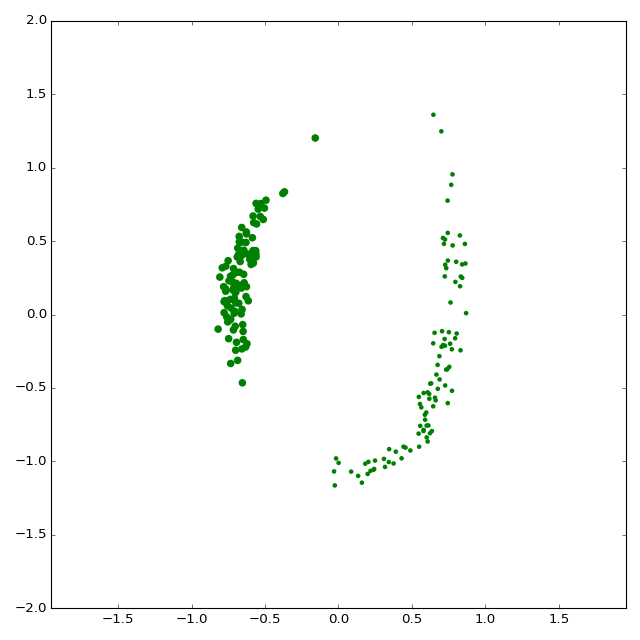

In [9]:
# To display our point cloud, we first have to turn our
# Pytorch variables (possibly GPU-enabled) into numpy arrays
nu_j = Nu_j.data.cpu().numpy() ; y_j = Y_j.data.cpu().numpy()

# We can then use standard matplotlib routines:
fig = plt.figure(figsize=(8,8))
ax  = plt.subplot(1,1,1)
ax.scatter( y_j[:,0], y_j[:,1], 6400*nu_j, 'g', edgecolors='none' )
plt.axis('equal')   ; plt.tight_layout()
ax.set_xlim([-2,2]) ; ax.set_ylim([-2,2])
fig.canvas.draw()

## The default model (starting point) v. our target dataset

We are about to use gradient descent to minimize

$$ \text{Cost}(w) ~=~ \text{d}( \mu_w, \nu ) ~=~ \text{d}( f_w \# \mu_0, \nu),$$

with some user-defined formula $\text{d}$. As a starting point, we should thus use default values for $w$, $f_w$ and $\mu_w$.

In [10]:
# A "default" polynomial model of degree 3.
MyModel = GenerativeModel(degree = 3)
(Mu_i, X_i) = MyModel(NPOINTS)

<IPython.core.display.Javascript object>


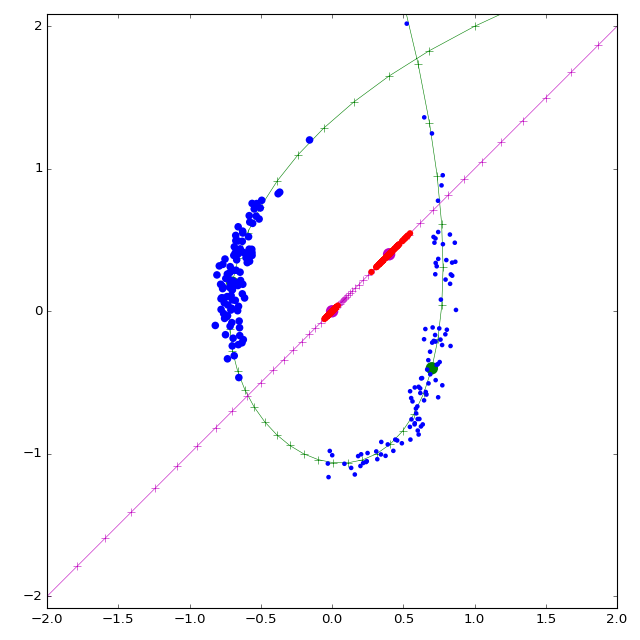

In [11]:
# Let's display it next to our "Ground Truth"!
nu_j = Nu_j.data.cpu().numpy() ; y_j = Y_j.data.cpu().numpy()
mu_i = Mu_i.data.cpu().numpy() ; x_i = X_i.data.cpu().numpy()

fig = plt.figure(figsize=(8,8))
ax  = plt.subplot(1,1,1)
GroundTruth.plot(ax, 'g')
MyModel.plot(    ax, 'm')
ax.scatter( y_j[:,0], y_j[:,1], 6400*nu_j, 'b', edgecolors='none' )
ax.scatter( x_i[:,0], x_i[:,1], 6400*mu_i, 'r', edgecolors='none' )

plt.axis('equal')   ; plt.tight_layout()
ax.set_xlim([-2,2]) ; ax.set_ylim([-2,2])
fig.canvas.draw()

## Get prepared for model optimization

To choose a useful model, we'll rely on visual intuition. Hence, we need to implement some visualization routines! For the sake of completeness, this tutorial provides the full code needed to run  the demo: If you're only interested in the mathematical aspects, feel free to skip this cell.

In [12]:
def plot_situation(fig, ax, ground_truth,     mymodel, 
                            training_measure, generated_measure,
                            info_type,        info             ) :
    """
    During the model-fitting loop, plots the evolution of the
    trained model next to our "ground truth".
    """
    # Turn PyTorch variables into numpy arrays --------------------------
    nu_j =  training_measure[0].data.cpu().numpy()
    y_j  =  training_measure[1].data.cpu().numpy()
    mu_i = generated_measure[0].data.cpu().numpy()
    x_i  = generated_measure[1].data.cpu().numpy()
    
    # Remove the colorbar if any, clear the axis ------------------------
    if len(ax.images) > 0 :
        cbars = ax.images[0].colorbar
        if cbars is not None : 
            cbars.remove()
    ax.clear()
    
    # Plot the "info" image/transport-plan, if any ----------------------
    if info is not None :
        info  = info.data.cpu().numpy()
        if info_type == "heatmap" :     # The info is a signal defined on the plane
            # We display it as a background image
            scale = np.amax(np.abs(info)) * 1.5
            cax   = ax.imshow(info, interpolation='bilinear', origin='lower', 
                      vmin = -scale, vmax = scale, cmap=cm.bwr, 
                      extent=(-2,2, -2, 2), zorder=-2)
            cbar  = fig.colorbar(cax)
        if info_type == "log" :     # The info is the log of a signal defined on the plane
            # We display it as a background image
            scale = np.amax(np.abs(info)) 
            cax   = ax.imshow(info, interpolation='bilinear', origin='lower', 
                      vmin = -3*scale, vmax = scale, cmap=cm.bwr, 
                      extent=(-2,2, -2, 2), zorder=-2)
            cbar  = fig.colorbar(cax)
        elif info_type == "transport" : # The info is a transport plan between the two measures
            # We display it as a "spider's web" linking the training measure to the generated one.
            segs = []
            # (the code below is here to produce fancy plots, no need to worry about it)
            for (xi, mui, gi) in zip(x_i, mu_i, info) :
                if False :
                    segs += [ [xi, y_j[np.argmax(gi)] ] ]
                else :
                    gi = gi / mui # gi[j] = fraction of the mass from "a" which goes to targetpoints[j]
                    for (yj, gij) in zip(y_j, gi) :
                        mass_per_line = 0.02
                        if gij >= mass_per_line :
                            nlines = np.floor(gij / mass_per_line)
                            ts     = np.linspace(-.005*(nlines-1), .005*(nlines-1), nlines)
                            for t in ts :
                                b = yj + t*np.array([ yj[1]-xi[1], -yj[0]+xi[0]])
                                segs += [[xi, b]]
                            
            line_segments = LineCollection(np.array(segs), linewidths=(.3,), 
                                           colors=[(.6,.8,1.)]*len(segs), linestyle='solid', zorder=-1)
            ax.add_collection(line_segments)
    
    # Plot the model "embeddings", and the associated point clouds ------
    ground_truth.plot(ax, 'g')
    mymodel.plot(ax, 'm')
    ax.scatter( y_j[:,0], y_j[:,1], 6400*nu_j, 'b', edgecolors='none' )
    ax.scatter( x_i[:,0], x_i[:,1], 6400*mu_i, 'r', edgecolors='none' )
    
    # Ready to plot ! ---------------------------------------------------
    plt.axis('equal')  ; plt.tight_layout() ; ax.set_xlim([-2,2]) ; ax.set_ylim([-2,2])
    fig.canvas.draw()

The optimization routine, though, is pretty important:

In [13]:
def FitModel(Model, Fidelity, EmpiricMeasure, name = "model", info_type = "heatmap", 
             lr=.1, NITS=500, eps=1e-2, **kwargs) :
    """
    Given an EmpiricMeasure (observed), and a Fidelity "error assessment formula"
    betweens measures, this routines fits an arbitrary generative Model
    to make it generate sample distributions close to the empirical one.
    """
    # We'll minimize "Fidelity( SampledModelDistribution, EmpiricMeasure )"
    # with respect to the model's parameters using a standard gradient-like
    # descent scheme. As we do not perform any kind of line search, 
    # this algorithm may diverge if the learning rate is too large !
    # For robust optimization routines, you may consider using
    # the scipy.optimize API with a "parameters <-> float64 vector" wrapper.
    optimizer = torch.optim.Adam(Model.parameters(), lr=lr, eps=eps)
    
    # We'll plot results on-the-fly, and save the list of costs across iterations
    fig = plt.figure(figsize=(10,8)) ; ax  = plt.subplot(1,1,1)
    costs = [] ; N = len(EmpiricMeasure[0]) ; NLOG = 50
    
    FitModel.nit = -1 ; FitModel.breakloop = False
    def closure():
        """
        Encapsulates a problem + display iteration into a single callable statement.
        This wrapper is needed if you choose to use LBFGS-like algorithms, which
        (should) implement a careful line search along the gradient's direction.
        """
        FitModel.nit += 1 ; i = FitModel.nit
        # Minimization loop --------------------------------------------------------------------
        optimizer.zero_grad()                      # Reset the gradients (PyTorch syntax...).
        GeneratedMeasure = Model(N)                # Draw a random sample from our model.
        Cost, info = Fidelity( GeneratedMeasure, EmpiricMeasure,  # Compute the discrepancy
                               info = (i%NLOG==0), **kwargs )     # wrt. the empirical distrib.
        costs.append(Cost.data.cpu().numpy()[0])   # Store the "cost" for plotting.
        Cost.backward(retain_graph=True)                            # Backpropagate to compute the gradient.
        
        if i % NLOG == 0: # Display the current model ------------------------------------------
            print("Iteration ",i,"Cost = ", Cost.data.cpu().numpy()[0])
            plot_situation(fig, ax, GroundTruth,    Model, 
                                    EmpiricMeasure, GeneratedMeasure,
                                    info_type, info                   )
            fig.savefig('output/'+name+'_'+str(i)+'.png', dpi=fig.dpi) # -----------------------
        
        if isnan(costs[-1]) : FitModel.breakloop = True
        return Cost
    
    for i in range(NITS+1) :           # Fixed number of iterations
        optimizer.step(closure)     # "Gradient descent" step.
        if FitModel.breakloop : break
            
        
    # Once the minimization is over, display the cost evolution --------------------------------
    fig = plt.figure(figsize=(8,8)) ;  ax  = plt.subplot(1,1,1)
    ax.plot(np.array(costs))
    fig.canvas.draw()

## Using a kernel norm

**Total Variation: a first dual norm.** Now, it's time to choose the last piece of the puzzle: the data attachment formula
$d(\mu_w, \nu)$ whose gradient (wrt. $w$) is going to drive our optimization routine.
Given two measures $\mu$ and $\nu$ on $\mathbb{R}^d$, one of the simplest distance that can be defined
is the Total Variation

$$\text{d}_{\text{TV}}(\mu,\nu) ~=~ \|\mu-\nu\|_{\infty}^{\star} ~=~ \sup_{\|f\|_{\infty} \leqslant 1} \int f \text{d}\mu - \int f \text{d}\nu,$$

using the dual norm on $L^{\infty}(\mathbb{R}^d, \mathbb{R})$.
Unfortunately, this formula is not suited *at all* to sampled, discrete probability measures with non-overlapping support:
If $\mu = \sum_i \mu_i\,\delta_{x_i}$ and $\nu = \sum_j \nu_j\,\delta_{y_j}$ with $\{x_i, \dots\}\cap\{y_j,\dots\} = \emptyset$, one can simply choose a function $f$ such that 

$$\forall \, i,~ f(x_i) ~=~+1 ~~~ \text{and} ~~~ \forall \, j, ~f(y_j) ~=~-1$$

to show that

$$\text{d}_{\text{TV}}(\mu, \nu) ~=~ |\mu| + |\nu| ~=~ 2 ~~~~ \text{as soon as $\text{supp}(\mu)$ and $\text{supp}(\nu)$ do not overlap.}$$

The gradient of the Total Variation distance between two sampled measures is thus completely uninformative, being zero for almost all configurations.

**Smoothing measures to create overlap.**
How can we fix this problem? An idea would be to choose a **blurring function $g$**, and compare
the blurred functions $g\star \mu$ and $g\star \nu$ by using, say, an $L^2$ norm:

$$\text{d}(\mu, \nu) ~=~ \| g\star(\mu-\nu)\|_2^2 ~=~ \langle g\star(\mu-\nu), g\star(\mu-\nu)\rangle_2.$$

But then, if we define $k = \tilde{g}\star g$, where $\tilde{g} = g \circ (x\mapsto -x)$ is the
mirrored blurring function, one gets

$$\text{d}_k(\mu,\nu) ~=~ \langle g\star(\mu-\nu), g\star(\mu-\nu)\rangle_2
~=~ \langle \mu-\nu, k\star(\mu-\nu)\rangle ~=~ \|\mu-\nu\|_k^2.$$

Assuming a few properties on $k$ (detailed below), $\text{d}_k$ is the quadratic norm associated with the $k$-scalar product between measures:

$$\langle \mu, \nu \rangle_k ~=~ \langle \mu, k\star \nu\rangle.$$

More specifically,

$$\bigg\langle \sum_i \mu_i \, \delta_{x_i} , \sum_j \nu_j\,\delta_{y_j} \bigg\rangle_k
~=~\bigg\langle \sum_i \mu_i \, \delta_{x_i} , \sum_j \nu_j\,\big(k\star\delta_{y_j}\big) \bigg\rangle
~=~\bigg\langle \sum_i \mu_i \, \delta_{x_i} , \sum_j \nu_j\,k(\,\cdot\,- y_j) \bigg\rangle
~=~ \sum_{i,j} k(x_i-y_j) \, \mu_i \nu_j.$$


In [14]:
def kernel_scalar_product(Mu, Nu, mode = "gaussian", s = 1.) :
    """
    Takes as input two measures Mu and Nu - encoded as (weights,points) pairs:
    
    Mu = \sum_i mu_i*\delta_{x_i}  ; Nu = \sum_j nu_j*\delta_{y_j}
    
    as well as parameters for a kernel function.
    
    Computes the kernel scalar product
    <Mu,Nu>_k = < Mu, k \star Nu >                    (convolution product)
              = \sum_{i,j} k(x_i-y_j) * mu_i * nu_j
    """
    (mu, x) = Mu ; (nu, y) = Nu
    k_nu = kernel_product(x,y,nu,mode,s)
    return torch.dot( mu.view(-1), k_nu.view(-1)) # PyTorch syntax for the L2 scalar product...

Having defined the scalar product, we then simply develop by bilinearity:

$$\|\mu-\nu\|_k^2 ~=~ \langle \mu,\mu \rangle_k \, -\, 2\langle \mu,\nu \rangle_k \,+\,\langle \nu,\nu \rangle_k.$$

In [15]:
def kernel_distance(Mu, Nu, info = False, mode = "gaussian", s = 1.) :
    """
    Hilbertian kernel (squared) distance between measures Mu and Nu,
    computed using the fact that
    
    |Mu-Nu|^2_k  =  <Mu,Mu>_k - 2 <Mu,Nu>_k + <Nu,Nu>_k
    
    If "info" is required, we output the values of
         k \star (Mu-Nu)  sampled on a uniform grid,
    to be plotted later.
    
    Strictly speaking, it would make more sense to display
         g \star (Mu-Nu)     where     g \star g = k
    as we would then have
          |Mu-Nu|^2_k  =  |g \star (Mu-Nu)|^2_{L^2}.
        
    But this is easy only for Gaussians...
    """
    D2 =   (   kernel_scalar_product(Mu,Mu,mode,s) \
           +   kernel_scalar_product(Nu,Nu,mode,s) \
           - 2*kernel_scalar_product(Mu,Nu,mode,s) )
    
    kernel_heatmap = None
    if info :
        # Create a uniform grid on the [-2,+2]x[-2,+2] square:
        res    = 100 ; ticks = np.linspace( -2, 2, res + 1)[:-1] + 1/(2*res) 
        X,Y    = np.meshgrid( ticks, ticks )
        points = Variable(torch.from_numpy(np.vstack( (X.ravel(), Y.ravel()) ).T).type(dtype), requires_grad=False)
        
        # Sample "k \star (Mu-Nu)" on this grid:
        kernel_heatmap   = kernel_product(points, Mu[1], Mu[0], mode, s) \
                         - kernel_product(points, Nu[1], Nu[0], mode, s)
        kernel_heatmap   = kernel_heatmap.view(res,res) # reshape as a "background" image
    return D2, kernel_heatmap

This formula looks good: points **interact** with each other as soon as $k(x_i,y_j)$ is non-negligible.
But if we want to get a genuine norm between measures, what hypothesis should we make on $k$?

This question was studied by mathematicians from the first half of the 20th century who developed the theory of Reproducing Kernel Hilbert Spaces - RKHS.
In our specific translation-invariant case (in which we "hardcode" convolutions), the results can be summed up as follow:
- Principled kernel norms are the ones associated to **kernel functions $k$** whose Fourier transform is *real-valued* and *positive* - think, Gaussian kernels:

$$\forall\, \omega \in \mathbb{R}^d, ~ \widehat{k}(\omega) > 0.$$
  

- For any such kernel function, there exists a unique blurring kernel function $g$ such that $g\star g = k$: Simply choose

$$\widehat{g}(\omega) ~=~ \sqrt{ \widehat{k}(\omega)}.$$

- These kernels define a **Hilbert norm** on a subset of $L^2(\mathbb{R}^d)$:

$$\|f\|_V^2 ~=~ \int_{\omega \in \mathbb{R}^d} \frac{|\widehat{f}(\omega)|^2}{\widehat{k}(\omega)} \,\text{d}\omega ~=~ \langle k^{(-1)} \star f\,,\, f\rangle$$
  where $k^{(-1)}$ is the deconvolution kernel associated to $k$.
  If we define 
  
  $$V ~=~ \big\{ f\in L^2(\mathbb{R}^d), ~\|f\|_V < \infty \big\}, $$
  
  then $(V, \|\cdot\|_V)$ is a Hilbert space of functions endowed with the scalar product
  
  $$ \langle f\,,\, g\rangle_V ~=~ \int_{\omega \in \mathbb{R}^d} \frac{\overline{\widehat{f}(\omega)} \,\widehat{g}(\omega)}{\widehat{k}(\omega)} \,\text{d}\omega ~=~ \langle k^{(-1)} \star f\,,\, g\rangle. $$
  
- **We focus on kernel functions such that for all points $x\in\mathbb{R}^d$, the evaluation at point $x$ is a continuous linear form on $V$.** That is,

$$ \delta_x : f\in (V, \|\cdot\|_V) \mapsto f(x) \in (\mathbb{R}, |\cdot|)$$

  is well-defined and continuous. A sufficient condition for this is to ask that $\widehat{k} \in L^1(\mathbb{R}^d)$ and continuous. Then, we show that the Riesz theorem identifies $\delta_x$ with the continuous function
$k\star \delta_x : y \mapsto k(y-x)$:

$$ \forall\, f\in V,~~  f(x)~=~\langle \delta_x\,,\, f\rangle ~=~ \langle k\star\delta_x\,,\, f\rangle_V.$$

- **Finite sampled measures can thus be identified with linear forms on $V$. The $k$-norm is nothing but the dual norm of $\|\cdot\|_V$:**

$$\forall\, \mu\in V^{\star}, ~\|\mu\|_k ~=~ \langle \mu\,,\, k\star \mu \rangle ~=~ \sup_{\|f\|_V \leqslant 1} \langle \mu\,,\, f\rangle.$$

All-in-all, **just like the TV distance, the kernel distance can be seen as the dual of a norm on a space of functions**. Whereas TV was associated to the infinity norm $\|\cdot\|_{\infty}$ on $L^{\infty}(\mathbb{R}^d)$, the kernel formulas are linked to Sobolev-like norms $\|\cdot\|_V$ on spaces of $k$-smooth functions, denoted by the letter $V$.

**In practice, to match sampled measures,** we need to choose kernel functions with:
- A null derivative at zero, and a large enough "blurring radius" to prevent overfit on the precise sampled locations of diracs.
- A heavy tail, to prevent isolated parts of $\mu_w$ and $\nu$ from being "forgotten" by the gradient.

<IPython.core.display.Javascript object>


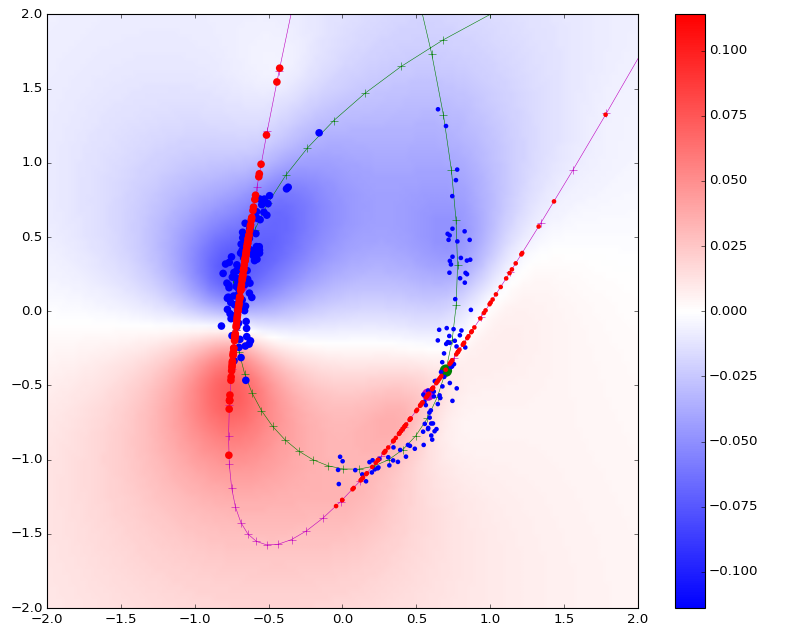

Iteration  0 Cost =  0.983868
Iteration  50 Cost =  0.0796914
Iteration  100 Cost =  0.0278499
Iteration  150 Cost =  0.0207648
Iteration  200 Cost =  0.0119243
Iteration  250 Cost =  0.0117462
Iteration  300 Cost =  0.0139592
Iteration  350 Cost =  0.0213788
Iteration  400 Cost =  0.00792599
Iteration  450 Cost =  0.0100627
Iteration  500 Cost =  0.01105
Iteration  550 Cost =  0.0108378
Iteration  600 Cost =  0.0122747
Iteration  650 Cost =  0.00941539
Iteration  700 Cost =  0.0103998
Iteration  750 Cost =  0.0185204
Iteration  800 Cost =  0.00654745
Iteration  850 Cost =  0.00799727
Iteration  900 Cost =  0.0162482
Iteration  950 Cost =  0.0318964
Iteration  1000 Cost =  0.0184731


<IPython.core.display.Javascript object>


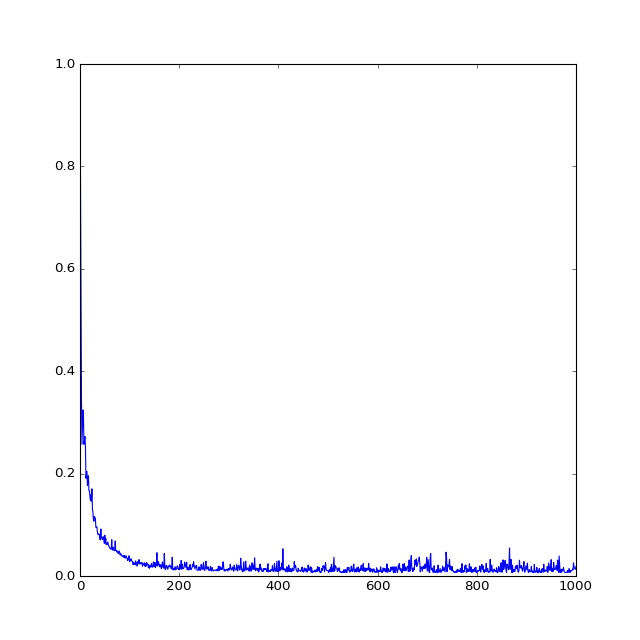

In [16]:
MyModel = GenerativeModel(degree = 2)

# Please play around with several kernel radii and profiles!
FitModel(MyModel, kernel_distance, (Nu_j, Y_j), NITS=1000, mode = "energy", s=.25)

## Using a Maximum-likelihood estimator

In the previous section, we've seen how to compare measures by seeing them as linear forms on a Sobolev-like space of functions. An other idea would be to **see the measure $\nu$ as the realization of an i.i.d. sampling according to the measure $\mu$, with likelihood**

$$\text{Likelihood}_\mu (\nu) ~=~ \text{Likelihood}_\mu \bigg(\sum_j \nu_j \delta_{y_j}\bigg)
~=~ \prod_j \text{Likelihood}_\mu(y_j)^{\nu_j}.$$

But which value could we attribute to the "likelihood of drawing $y$, given the measure $\mu$"?
Since $\mu$ is discrete, supported by the $x_i$'s, interpreting it as a density wouldn't be practical at all...
Thankfully, there's a simple solution: we could **convolve** $\mu$ with a simple density function $k>0$ of mass 1 - say, a Gaussian - and thus end up with a probability measure $k\star \mu$ which is absolutely continous wrt. the Lebesgue measure, with density

$$\text{Likelihood}_{k\star\mu}(y) ~=~ \sum_i k(y-x_i) \,\mu_i > 0 ~~ \text{ for all $y\in\mathbb{R}^d$}.$$

From a probabilistic point of view, using this density function as a "model" is equivalent to assuming that the random variable $y$ is generated as a sum $x + w$, where $x$ and $w$ are two independent variables of laws equal to $\mu$ and $k\cdot\text{Lebesgue($\mathbb{R}^d$)}$.

Given $\mu$, $\nu$ and a symmetric kernel function $k$, we can thus choose to **maximize the likelihood**

$$\text{Likelihood}_{k\star\mu} (\nu) ~=~ \prod_j \big( \sum_i k(x_i-y_j) \,\mu_i \big)^{\nu_j},$$

i.e. to **minimize the negative log-likelihood**

$$\text{d}_{\text{ML},k}(\mu,\nu) ~=~ - \sum_j \log\big( \sum_i k(x_i-y_j) \,\mu_i \big)\, \nu_j.$$


**Information theoretic interpretation.** Before going any further, we wish to stress the link between maximum-likelihood estimators and the Kullback-Leibler divergence. In fact, **if we assume that a measure $\nu_{\text{gen}}$ is absolutely continuous wrt. the Lebesgue measure $\lambda$,** then

$$\text{KL}(\nu_{\text{gen}}\,|\, \mu) 
~=~ \int \log \bigg( \frac{\text{d} \nu_{\text{gen}}}{\text{d}\mu} \bigg) \,\text{d}\nu_{\text{gen}}
~=~ \int \log \bigg( \frac{\text{d} \nu_{\text{gen}} / \text{d}\lambda }{\text{d}\mu/ \text{d}\lambda} \bigg) \,\text{d}\nu_{\text{gen}}
~=~ \int \log \bigg( \frac{\text{d} \nu_{\text{gen}}}{\text{d}\lambda} \bigg) \,\text{d}\nu_{\text{gen}}
~-~ \int \log \bigg( \frac{\text{d} \mu}{\text{d}\lambda} \bigg) \,\text{d}\nu_{\text{gen}}$$

$$\text{i.e.}~~ \text{KL}(\nu_{\text{gen}}\,|\, \mu) 
~=~ \text{KL}(\nu_{\text{gen}}\,|\, \lambda) 
~-~ \int \log \bigg( \frac{\text{d} \mu}{\text{d}\lambda} \bigg) \,\text{d}\nu_{\text{gen}}
~~~~ \text{so that}~~ 
~- \int \log \bigg( \frac{\text{d} \mu}{\text{d}\lambda} \bigg) \,\text{d}\nu_{\text{gen}}
~=~ \text{KL}(\nu_{\text{gen}}\,|\, \mu)  - \text{KL}(\nu_{\text{gen}}\,|\, \lambda) .$$

Hence, as the sampled measure $\nu$ weakly converges towards a measure $\nu_{\text{gen}}$,

$$d_{\text{ML},k}(\mu,\nu) ~\longrightarrow~ \text{KL}(\nu_{\text{gen}}\,|\,k\star \mu) ~-~ \text{KL}(\nu_{\text{gen}}\,|\, \lambda). $$

As a function of $\mu$, this formula is minimized if and only if $~~k\star \mu = \nu_{\text{gen}}$.

**Practical implementation.** As noted by the careful reader, the maximum-likelihood cost $\text{d}_{\text{ML},k}(\mu,\nu)$ can be computed as the scalar product between the vector of weights $(\nu_j)$ and the pointwise logarithm of the **Kernel Product** $\text{KP}\big( (y_j), (x_i), (\mu_i) \big)$ - up to a negative sign.
So, is using our `kernel_product` routine a sensible thing to do? **No, it isn't.**

Indeed, if a point $y_j$ is far away from the support $\{x_i, \dots\}$ of the measure $\mu$, $\sum_i k(x_i-y_j)\,\mu_i$ can be prohibitively small. Just remember how fast a Gaussian kernel decreases to zero!
If this sum's order of magnitude is close to the floating point precision (for `float32` encoding, around $10^{-7}\simeq e^{-4^2}$), applying to it a logarithmic function is just asking for trouble.

**Additive v. Multiplicative formulas.** In the previous section, we defined the **kernel distance** $\text{d}_k$ and never encountered any accuracy problem. This is because, as far as **sums** are concerned, small "kernel's tail" values can be safely discarded - providing a reasonable balance in the weights' distribution. However, when using maximum likelihood estimation, all the values are **multiplicated with each other**: the smaller ones cannot be "neglected" anymore, as they very much determine the magnitude of the whole product. In the log-domain, near-zero values of the density $\big(k\star \mu\big)(y_j)$ have a large influence on the final result!

**Numerical stabilization.** We now understand the importance of **magnitude-independent schemes** as far as multiplicative formulas are concerned. Programs which do not spiral out of control when applied to values of the order of $10^{-100}$. How do we achieve such robustness? For arbitrary expressions, the only solution may be to increase the memory footprint of floating-point numbers...

But in this specific "Kernel Product" case, a simple trick will do wonders: using a **robust log-sum-exp expression**.
Let's write

$$U_i ~=~ \log(\mu_i), ~~~~~~~ C_{i,j}~=~ \log\big( k(x_i-y_j)\big) ~~~ \text{(given as a stable explicit formula)}.$$

Then, the log-term in the ML distance can be written as

$$\log\big(k\star\mu\big)(y_j)
~=~ \log\bigg( \sum_i k(x_i-y_j) \,\mu_i \bigg)
~=~ \log\bigg( \sum_i \exp \big( C_{i,j} + U_i \big) \bigg).$$

This expression lets us see that **the order of magnitude of $\big(k\star\mu\big)(y_j)$ can be factored out easily**. Simply compute

$$M_j~=~ \max_i C_{i,j} + U_i, ~~~~~ \text{and remark that} ~~~~~
\log\big(k\star\mu\big)(y_j) 
~=~ M_j \,+\, \log\bigg( \sum_i \exp \big( C_{i,j} + U_i - M_j \big) \bigg).$$

As the major exponent has been pulled out of the sum, we have effectively solved our accuracy problems.

In [17]:
if backend == "pytorch" :
    def log_sum_exp(mat, dim):
        """
        Computes the log-sum-exp of a matrix with a numerically stable scheme, 
        in the user-defined summation dimension: exp is never applied
        to a number >= 0, and in each summation row, there is at least
        one "exp(0)" to stabilize the sum.
        
        For instance, if dim = 1 and mat is a 2d array, we output
                    log( sum_j exp( mat[i,j] )) 
        by factoring out the row-wise maximas.
        """
        max_rc = torch.max(mat, dim)[0]
        return max_rc + torch.log(torch.sum(torch.exp(mat - max_rc.unsqueeze(dim)), dim))
    
    def kernel_product_log(x,y,nu_log, mode = "gaussian", s = 1.) :
        """
        Computes log( K(x_i,y_j) @ nu_j) = log( \sum_j k(x_i-y_j) * nu_j) in the log domain,
        where k is a kernel function (say, a Gaussian) of deviation s.
        """
        x_i = x.unsqueeze(1)        # Shape (N,d) -> Shape (N,1,d)
        y_j = y.unsqueeze(0)        # Shape (M,d) -> Shape (1,M,d)
        xmy = ((x_i-y_j)**2).sum(2) # N-by-M matrix, xmy[i,j] = |x_i-y_j|^2
        if   mode == "gaussian"     : C =  - xmy / (s**2) 
        elif mode == "laplace"      : C =  - torch.sqrt(xmy + (s**2)) 
        elif mode == "energy"       : C =  -.25 * torch.log( xmy + (s**2) )
        elif mode == "exponential"  : C =  - torch.sqrt(xmy) / s 
        return log_sum_exp( C + nu_log.view(1,-1) , 1 ) # Matrix product between the Kernel operator and the vector nu.
    
elif backend == "libkp" :
    None

In [18]:
def kernel_neglog_likelihood(Mu, Nu, info = False, mode = "gaussian", s = 1.) :
    """
    Returns the negative log likelihood of the sampled measure Nu,
    assuming an i.i.d. sampling from the density Mu convolved with
    a kernel specified by mode and s.
    
    The summation is done in the log-domain, for increased numerical stability.
    
    N.B.: for computational efficiency, kernel computations are "raw",
          not normalized to have unit mass on R^d.
          Hence, this log-likelihood can not be rigorously interpreted
          as the log of a density function of total mass 1.
          This can be fixed by adding the correct normalization constant
          in front of the log-result, which is useful if one wants
          to optimize on the kernel's parameters.
    
    If 'info' is True, kernel_heatmap is a background image, displaying
    the real-valued field
       log( d(k*mu)/dl ) (y) = log( sum_i k(y-x_i)*mu_i ) 
    """
    loglikelihoods = kernel_product_log(Nu[1], Mu[1], Mu[0].log(), mode, s)
    dMuNu          = - torch.dot( loglikelihoods.view(-1)  , Nu[0].view(-1) )
    
    kernel_heatmap = None
    if info :
        # Create a uniform grid on the [-2,+2]x[-2,+2] square:
        res    = 100 ; ticks = np.linspace( -2, 2, res + 1)[:-1] + 1/(2*res) 
        X,Y    = np.meshgrid( ticks, ticks )
        points = Variable(torch.from_numpy(np.vstack( (X.ravel(), Y.ravel()) ).T).type(dtype), requires_grad=False)
        
        # Sample the log-likelihood on this grid:
        kernel_heatmap   = kernel_product_log(points, Mu[1], Mu[0].log(), mode, s)
        kernel_heatmap   = kernel_heatmap.view(res,res) # reshape as a "background" image
    return dMuNu, kernel_heatmap

<IPython.core.display.Javascript object>


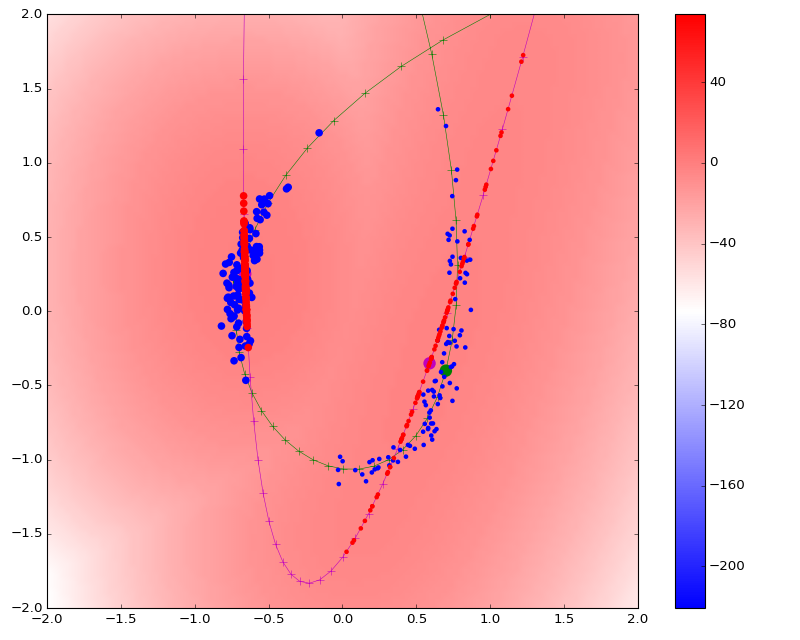

Iteration  0 Cost =  12.1658
Iteration  50 Cost =  2.17226
Iteration  100 Cost =  2.08372
Iteration  150 Cost =  2.09516
Iteration  200 Cost =  2.10905
Iteration  250 Cost =  2.07919
Iteration  300 Cost =  2.08036
Iteration  350 Cost =  2.0564
Iteration  400 Cost =  2.09342
Iteration  450 Cost =  2.0678
Iteration  500 Cost =  2.06973


<IPython.core.display.Javascript object>


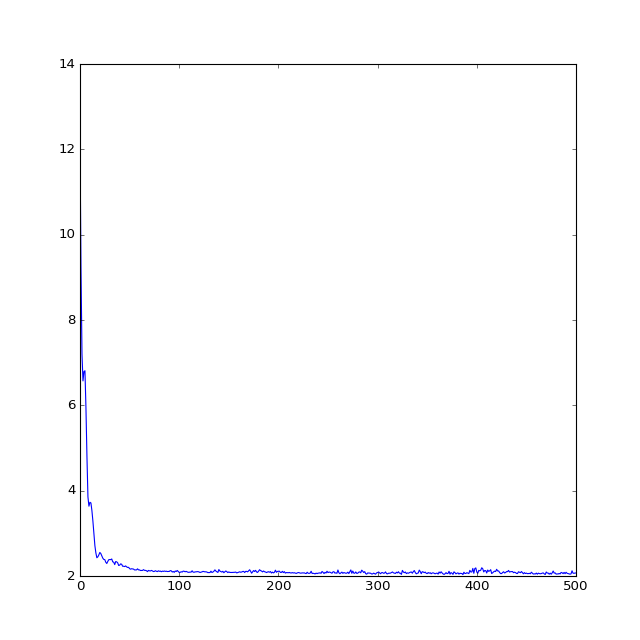

In [19]:
MyModel = GenerativeModel(degree = 2)
# Please play around with several kernel radii and profiles!
FitModel(MyModel, kernel_neglog_likelihood, (Nu_j, Y_j), info_type="log", name="loglikelihood", 
         mode = "gaussian", s=.25)

## Using an Optimal Transport distance

In the previous two sections, we've seen how to compute **kernel distances**, which are the duals of Sobolev-like norms on space of functionals, as well as **Maximum Likelihood scores**, which can be understood as approximations of the Kullback-Leibler divergence.
Last but not least, we now show how to compute **Optimal Transport** plans efficiently, ending up on Wasserstein-like distances between unlabeled measures.

**Getting used to Optimal Transport.** The modern OT theory relies on a few objects
and problems that we now briefly recall. For a complete reference on the subject,
you may find useful Filippo Santambrogio's *Optimal Transport for Applied Mathematicians* (2015)
or Peyré-Cuturi's *Computational Optimal Transport* (2017), depending on your
background.

**Kantorovitch problem.** 
Given $\mu = \sum_i \mu_i \,\delta_{x_i}$ and $\nu = \sum_j \nu_j\,\delta_{y_j}$ we wish
to find a **Transport Plan** $\Gamma$ (a measure on the product
$\{x_i,\dots\}\times\{y_j,\dots\}$, encoded as an $N$-by-$M$ matrix $(\Gamma(x_i\leftrightarrow y_j))=(\gamma_{i,j})$) which
is a solution of the following optimization problem:

$$\text{minimize} ~~~ \langle \Gamma, C \rangle ~=~ \sum_{i,j} \gamma_{i,j} C_{i,j}$$
$$\text{subject to:} ~~~~ \forall\,i,j,~~ \gamma_{i,j} \geqslant 0, 
~~ \sum_j \gamma_{i,j} ~=~ \mu_i,
~~ \sum_i \gamma_{i,j} ~=~ \nu_j,$$

where the **Cost matrix** $C_{i,j} = c(x_i,y_j)$ encodes
the cost of moving a unit mass from point $x_i$ to point $y_j$.

**Wasserstein distance.** If one uses $c(x_i,y_j)=\|x_i-y_j\|^2$,
the optimal value of the above problem is called the **Wasserstein distance**
$\text{d}_{\text{Wass}}(\mu,\nu)$ between measures $\mu$ and $\nu$.
Its theoretical properties are plentiful... But can we compute it efficiently?
**In the general high-dimensional case: no, we can't.**
Indeed, the Kantorovitch problem above is a textbook **Linear optimization problem**,
combinatorial by nature. Even though the simplex algorithm or other classical routines
output exact solutions, they do so at a prohibitive cost: at least cubic wrt. the number of samples.

**Entropic regularization.**
Thankfully, we can however **compute approximate transport plans at a much lower cost**.
Given a small regularization parameter $\varepsilon$, the idea is to
add an **entropic barrier** to the Linear Kantorovitch problem and solve

$$\text{minimize} ~~~ \langle \Gamma, C \rangle - \varepsilon \text{H}(\Gamma) 
~=~ \sum_{i,j} \gamma_{i,j} C_{i,j} + \varepsilon\,\sum_{i,j} \gamma_{i,j}\, \log \gamma_{i,j}$$
$$\text{subject to:} ~~~~ \forall\,i,j,~~ \gamma_{i,j} \geqslant 0, 
~~ \sum_j \gamma_{i,j} ~=~ \mu_i,
~~ \sum_i \gamma_{i,j} ~=~ \nu_j.$$

An important property of the $x\mapsto x\log x$ function is that it has
**a $-\infty$ derivative at location $x=0$**. Since the main objective
function $\langle \Gamma, C\rangle$ is linear wrt. the $\gamma_{i,j}$'s, this implies that
the optimal value of the regularized problem is attained **in the relative interior
of the simplex, defined by the constraints:**

$$ \Gamma ~>~0, ~~~ \Gamma 1 ~=~ \mu, ~~~ \Gamma^T 1 ~=~\nu.$$

Hence, **the optimum is necessarily reached at a critical point of our constrained problem**.
At the optimum $\Gamma^{\star}$, the gradient of the objective can thus be written as a linear combination of
the equality constraints' gradients:

$$\exists\, (u_i)\in\mathbb{R}^N, ~(v_j)\in\mathbb{R}^M,~~ \forall\,i,j,~~~ C_{i,j} + \varepsilon \,(1+\log \gamma_{i,j}^{\star})~=~ u_i + v_j $$

where $u_i$ is the coefficient associated to the constraint $\sum_j \gamma_{i,j} = \mu_i$, as $v_j$ is linked to $\sum_i \gamma_{i,j} = \nu_j$.

All in all, we see that the optimal transport plan $(\gamma^{\star}_{i,j}) \in \mathbb{R}_+^{N\times M}$ is
characterized by **a single pair of vectors $(u,v) \in \mathbb{R}^{N+M}$**:

$$\forall\,i,j,~~~~~ 1+\log \gamma^{\star}_{i,j} ~=~ (u_i+v_j-C_{i,j})/\varepsilon$$

$$\text{i.e.}~~~ \Gamma^{\star}~=~ \text{diag}(a_i)\,K_{i,j}\,\text{diag}(b_j)$$

$$\text{with}~~~ a_i~=~ \tfrac{1}{\sqrt{e}}\,\exp(u_i/\varepsilon), 
~~ b_j~=~\tfrac{1}{\sqrt{e}}\,\exp(v_j/\varepsilon), ~~ K_{i,j}~=~\exp(-C_{i,j}/\varepsilon).$$

Consequences of this "critical point equation" are twofold:

- The **dimension of the space in which we should search the optimal transport plan is greatly reduced**,
  jumping from $(M\times N)$ to $(M+N)$ - the adjoint variables associated to the equality constraints. 
  Furthermore, the optimal value of the cost can be computed using this **cheap formula**:
  
  $$\langle \Gamma^{\star}, C\rangle - \varepsilon \text{H}(\Gamma^{\star}) 
  ~=~ \sum_{i,j} \gamma^{\star}_{i,j} \,\big( C_{i,j} + \varepsilon\,\log \gamma^{\star}_{i,j} \big)
  ~=~ \sum_{i,j} \gamma_{i,j} \,(u_i + v_j - \varepsilon) $$
  
  $$\text{i.e.}~~~ \langle \Gamma^{\star}, C\rangle - \varepsilon \text{H}(\Gamma^{\star}) 
  ~=~ \langle \mu, u \rangle + \langle \nu, v\rangle- \varepsilon
  ~=~ \varepsilon\,\big[ \langle \mu, \log(a) \rangle + \langle \nu, \log(b)\rangle\big].$$
  
- The optimal transport plan can be expressed as **the positive scaling of a positive kernel matrix $K$**. But in the meantime, it should also satisfy the two marginal constraints which can be written in terms of $(a_i)$ and $(b_j)$:
    
$$ a_i ~=~ \frac{\mu_i}{(Kb)_i}, ~~~~ b_j ~=~ \frac{\nu_j}{(K^Ta)_j}.$$

As was first remarked by Marco Cuturi in his 2013 paper, *Sinkhorn Distances: Lightspeed Computation of Optimal Transportation Distances*,
this reformulation of (entropic regularized) Optimal Transport can be linked to the **Sinkhorn Theorem**: It admits a unique solution $(a,b) \in \mathbb{R}^{N+M}$, which can be approached iteratively by applying the steps

$$ a^{(0)} = (1,\dots, 1),~ b^{(0)} = (1,\dots, 1), ~~~~~~ a^{(n+1)} ~=~ \frac{\mu}{Kb^{(n)}}, ~~~~ b^{(n+1)} ~=~ \frac{\nu}{K^Ta^{(n+1)}}.$$

Hence, **one can solve the regularized Optimal Transport problem by iterating kernel products (aka. discrete convolutions) and pointwise divisions, on variables which have the same memory footprint as the input measures!** 

In [20]:
def wasserstein_distance(Mu, Nu, info = False, mode = "gaussian", s = .2) :
    """
    Executes the Sinkhorn algorithm to compute an approximate Optimal Transport
    cost between Mu and Nu, using an entropic regularization of strength
    epsilon = s^2.
    """
    eps = s**2
    A   = Variable(torch.ones(Mu[0].size()).type(dtype))
    B   = Variable(torch.ones(Nu[0].size()).type(dtype))
    for it in range(1000) : # Sinkhorn loop ---------------------------------------
        A_prev = A
        A = Mu[0] / kernel_product(Mu[1], Nu[1], B,mode,s).view(-1)
        B = Nu[0] / kernel_product(Nu[1], Mu[1], A,mode,s).view(-1)
        err = (A.log()-A_prev.log()).abs().mean().data.cpu().numpy()
        if err < 1e-5 :
            print(it, ": ", err, ", ", end="")
            break
    
    # At convergence, one can compute the cost using  -----------------------------   
    # the "dual", cheap formula in terms of the adjoint variables:
    D2_d = eps * ( torch.dot(Mu[0].view(-1), A.log().view(-1)) \
                 + torch.dot(Nu[0].view(-1), B.log().view(-1)) )
        
    transport_plan = None
    if info : # If required, compute the full \Gamma^{\star}. This is expensive to plot!
        x_i = Mu[1].unsqueeze(1) ; y_j = Nu[1].unsqueeze(0)
        xmy = ((x_i-y_j)**2).sum(2)
        if mode == "gaussian" : K = torch.exp( - xmy / (s**2) )
        else : raise NotImplementedError("Please implement your custom distance+kernel !")
            
        transport_plan = K * (A.view(-1,1) * B.view(1,-1))
    return D2_d, transport_plan

**N.B.:** In the Sinkhorn loop, you may wish to **compute and store the Kernel matrix $K(x_i,y_j)$ in advance**. This will greatly reduce the computation time of the Sinkhorn-Wasserstein cost. Note, however, that this is only tractable for **small point clouds** ($M,N < 10,000$) as the full $M$-by-$N$ matrix may not fit in the GPU memory.

<IPython.core.display.Javascript object>


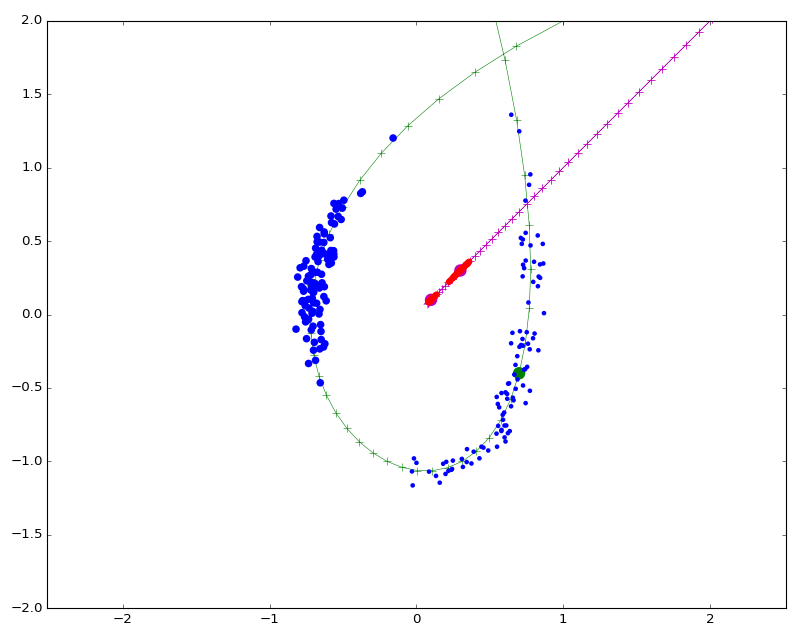

Iteration  0 Cost =  nan


<IPython.core.display.Javascript object>


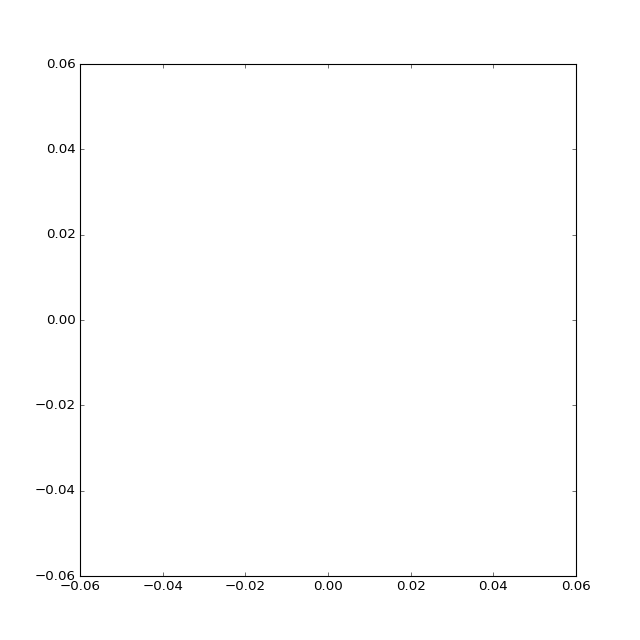

In [21]:
MyModel = GenerativeModel(degree = 2)
FitModel(MyModel, wasserstein_distance, (Nu_j, Y_j), 
         info_type = "transport", name = "OT", mode="gaussian", s = .15)

## Sinkhorn  algorithm in the log domain

Is the scheme presented above stable enough? No, it isn't. Indeed, as discussed in the section dedicated to Maximum likelihood estimators, **if we use kernels in multiplicative formulas, we should favor log-domain implementations**. As seen below, our `kernel_product_log` operator works just fine:

In [22]:
def wasserstein_distance_log(Mu, Nu, info = False, s = .2, tau=-.5) :
    """
    Log-domain implementation of the Sinkhorn algorithm,
    provided for numerical stability.
    The "multiplicative" standard implementation is replaced
    by an "additive" logarithmic one, as:
    - A is replaced by U_i = log(A_i) = (u_i/eps - .5)
    - B is replaced by V_j = log(B_j) = (v_j/eps - .5)
    - K_ij is replaced by C_ij = - eps * log(K_ij)
                               = |X_i-Y_j|^2
    (remember that epsilon = eps = s^2)
    
    The update step:
    
    " a_i = mu_i / \sum_j k(x_i,y_j) b_j "
    
    is thus replaced, applying log(...) on both sides, by
    
    " u_i = log(mu_i) - log(sum( exp(-C_ij/eps) * exp(V_j) )) ] "
    
    N.B.: By default, we use a slight extrapolation to let the algorithm converge faster.
          As this may let our algorithm diverge... Please set tau=0 to fall back on the
          standard Sinkhorn algorithm.
    """
    eps = s**2
    U   = Variable(torch.zeros(Mu[0].size()).type(dtype))
    V   = Variable(torch.zeros(Nu[0].size()).type(dtype))
    for it in range(1000) :
        U_prev = U
        U = tau*U + (1-tau)*( torch.log(Mu[0]) - kernel_product_log(Mu[1], Nu[1], V, "gaussian", s).view(-1) ) 
        V = tau*V + (1-tau)*( torch.log(Nu[0]) - kernel_product_log(Nu[1], Mu[1], U, "gaussian", s).view(-1) )
        err = (eps * (U-U_prev).abs().mean()).data.cpu().numpy()
        if err < 1e-5 :
            print(it, ", ", end="")
            break
    D2 = eps * ( torch.dot(Mu[0].view(-1), U.view(-1) ) \
               + torch.dot(Nu[0].view(-1), V.view(-1) ) )
    
    transport_plan = None
    if info :
        C = ((Mu[1].unsqueeze(1) - Nu[1].unsqueeze(0) )**2).sum(2)
        transport_plan = ( U.view(-1,1)+V.view(1,-1) - C/eps ).exp()
    return D2, transport_plan

<IPython.core.display.Javascript object>


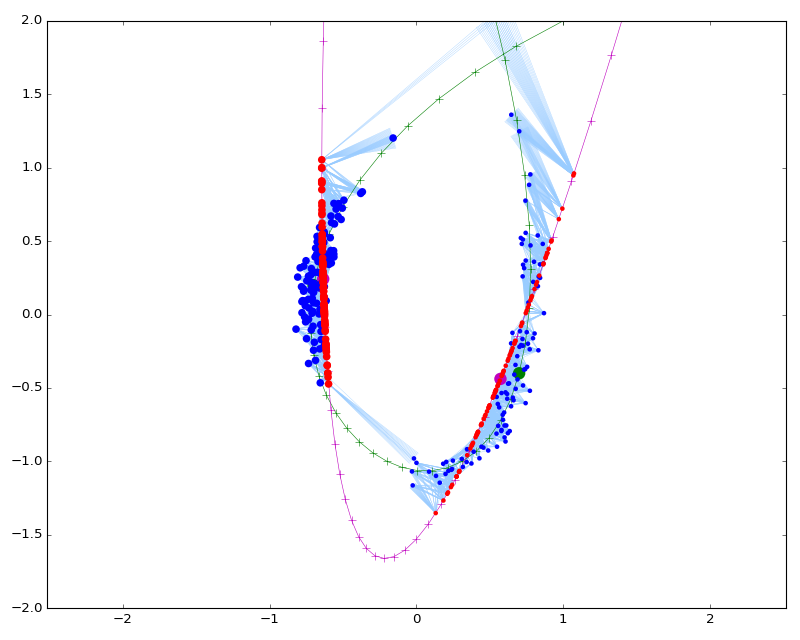

17 , Iteration  0 Cost =  0.561352


/home/jean/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:51: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


19 , 24 , 21 , 37 , 49 , 67 , 65 , 69 , 39 , 61 , 34 , 36 , 63 , 33 , 63 , 62 , 84 , 102 , 131 , 254 , 313 , 217 , 450 , 457 , 595 , 461 , 435 , 505 , 391 , 524 , 848 , 516 , 662 , 404 , 614 , 788 , 327 , 630 , 550 , 596 , 524 , 995 , 766 , 648 , 520 , Iteration  50 Cost =  -0.13936
860 , 578 , 592 , 952 , 914 , 652 , 807 , 571 , 596 , 976 , 734 , 765 , 785 , 656 , 539 , 816 , 101 , Iteration  100 Cost =  -0.153721
649 , 750 , 92 , Iteration  150 Cost =  -0.159721
106 , 78 , 99 , 98 , 80 , 107 , 112 , Iteration  200 Cost =  -0.159605
63 , 119 , 113 , Iteration  250 Cost =  -0.159999
90 , 90 , 99 , 100 , Iteration  300 Cost =  -0.158106
Iteration  350 Cost =  -0.161266
125 , 792 , 495 , 652 , 904 , 724 , 741 , 804 , 793 , 827 , 912 , 974 , 743 , 998 , Iteration  400 Cost =  -0.159387
427 , 863 , 650 , Iteration  450 Cost =  -0.154769
108 , 121 , 566 , 946 , 947 , 802 , 709 , 71 , 868 , 596 , Iteration  500 Cost =  -0.154529


<IPython.core.display.Javascript object>


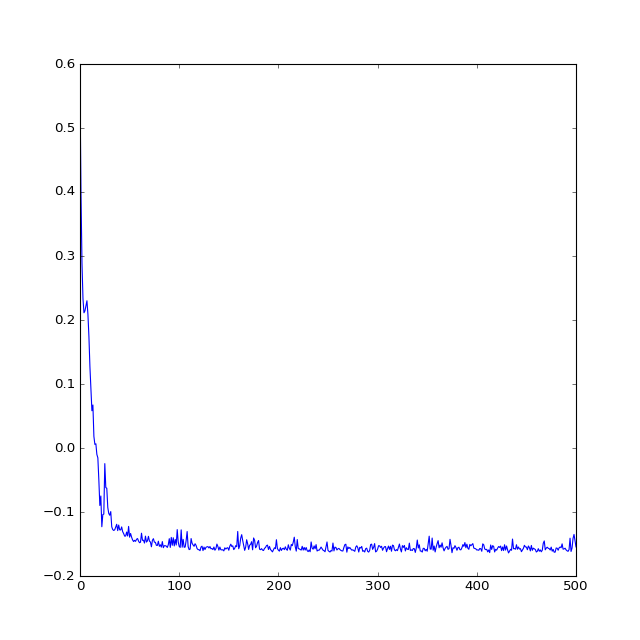

In [23]:
MyModel = GenerativeModel(degree = 2)
FitModel(MyModel, wasserstein_distance_log, (Nu_j, Y_j), info_type = "transport", name = "wasserstein", s = .15)

## Playing with the Sinkhorn algorithm

The Sinkhorn-Wasserstein distance looks good... But it still requires about 100-500 kernel convolutions to be computed, depending on the regularization strength. Hence, couldn't we use the **intermediate results of the Sinkhorn loop** as cheap approximations to the optimal transport costs? We display below an example of "algorithmic compromise" which performs well in practice.

Thanks to autodiff libraries, trying out new Wasserstein-like costs is easy; however, finding "the right algorithm" which combines efficiency with explainability is still very much a research topic! 

In [30]:
def sinkhorn_loop(Mu, Nu, s, nits, tau=-.5) :
    eps = s**2
    U   = Variable(torch.zeros(Mu[0].size()).type(dtype))
    V   = Variable(torch.zeros(Nu[0].size()).type(dtype))
    for it in range(nits) :
        U = tau*U + (1-tau)*( torch.log(Mu[0]) - kernel_product_log(Mu[1], Nu[1], V, "gaussian", s).view(-1) ) 
        V = tau*V + (1-tau)*( torch.log(Nu[0]) - kernel_product_log(Nu[1], Mu[1], U, "gaussian", s).view(-1) )
        
    D2 = eps * ( torch.dot(Mu[0].view(-1), U.view(-1)) \
               + torch.dot(Nu[0].view(-1), V.view(-1)) )
    
    return D2


def sinkhorn_distance_log(Mu, Nu, info = False, s = .2, nits = 10) :
    """
    Inspired by "Learning Generative Models with Sinkhorn Divergences"
    by Genevay, Peyré and Cuturi (2017, arxiv.org/abs/1706.00292), we carelessly compute
    a loss function using only a handful of sinkhorn iterations. 
    The expression below is designed to give "relevant" results even
    when s is large or when the Sinkhorn loop has not fully converged.
    
    This formula uses the "dual" Sinkhorn cost and has not been documented anywhere: 
    it is a mere experiment, a compromise between the mathematical theory of OT
    and algorithmic efficiency. As such, it lacks a proper interpretation
    and we prefer not to output any misleading 'informative' transport plan.
    """
    
    Loss = 2*sinkhorn_loop(Mu,Nu, s,nits) \
           - sinkhorn_loop(Mu,Mu, s,nits) - sinkhorn_loop(Nu,Nu, s,nits)
    transport_plan = None
    return Loss, transport_plan

<IPython.core.display.Javascript object>


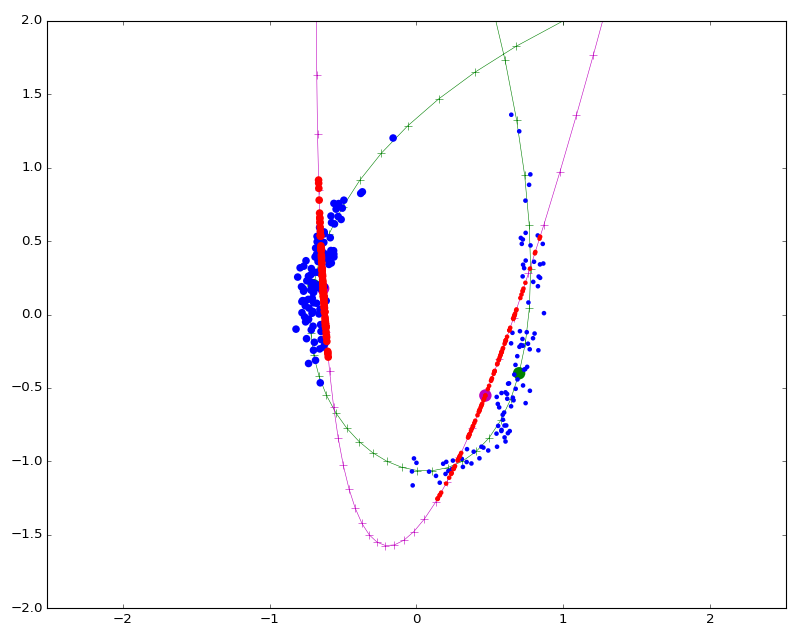

Iteration  0 Cost =  1.48423
Iteration  50 Cost =  0.0839656
Iteration  100 Cost =  0.0789928
Iteration  150 Cost =  0.0711281
Iteration  200 Cost =  0.0529122
Iteration  250 Cost =  0.0456157
Iteration  300 Cost =  0.0568371
Iteration  350 Cost =  0.0327446
Iteration  400 Cost =  0.0395203
Iteration  450 Cost =  0.0637386
Iteration  500 Cost =  0.0687691


<IPython.core.display.Javascript object>


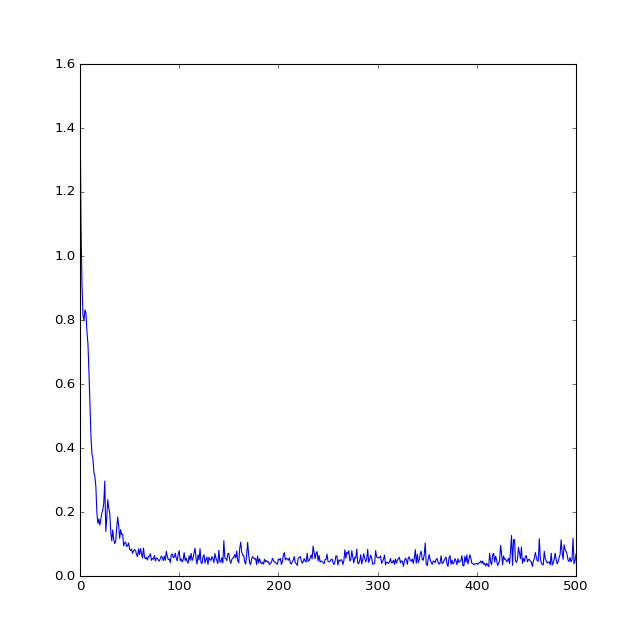

In [33]:
MyModel = GenerativeModel(degree = 2)
FitModel(MyModel, sinkhorn_distance_log, (Nu_j, Y_j), info_type="transport", name="sinkhorn", s=.25)

## Conclusion

In this notebook, we've presented three major families of "distance" costs between probability measures:
- Kernel distances (also known as *Maximum Mean Discrepancies*), which descend from dual norms on **Sobolev-like spaces of functions**.
- Empirical log-likelihoods, which converge towards **Kullback-Leibler discrepancies**.
- Sinkhorn distances, designed as cheap approximations of Optimal Transport costs; they can be linked to dual norms on **Lipschitz-like spaces of functions**.

Interestingly, the three of them use **the same atomic operation: the Kernel Product**, possibly implemented in the log-domain. As it is a GPU-friendly operation, using these formulas results in scalable algorithm.
But which one should we use in practical applications?
This is the main question, that can only be answered with respect to specific applications and datasets. 

**A rule of thumb:** kernel distances and log-likelihoods are both cheap, and differ in the way they handle **outliers** and isolated $x_i$'s or $y_j$'s. 
With kernel distances, they are nearly *forgotten* as the tail of the kernel function $k$ goes to zero;
in the likelihood case, though, since $-\log k(x) \rightarrow +\infty$ when $x$ grows, outliers tend to have a large influence on the overall cost and its gradient.
More recently introduced, Sinkhorn distances tend to be both interpretable and robust... At a high computational cost. Computing a full transport plan to simply get a *gradient* is overkill for most applications, and future works will certainly focus on cheap approximations that interpolate between OT and simpler theories.

To get your own intuition on the subject, feel free to re-run this notebook with different parameters' values!
